<a href="https://colab.research.google.com/github/iankim20/MAIC-AI-Challenge_hypotension-prediction/blob/main/autoencoder_LSTM_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "/content/drive/My Drive/MAIC_data"

/content/drive/My Drive/MAIC_data


# Run **TPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import math, re, os
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import keras

# print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
INFO:tensorflow:Initializing the TPU system: grpc://10.60.33.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.33.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# !gcloud init

In [ ]:
# !gsutil -m cp processed_data/tfrec/*.tfrec gs://tfrec_tak/

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
# from tensorflow import set_random_seed
# set_random_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
import random

GCS_DS_PATH = "gs://tfrec_tak"

TRAINING_NONEVENT = tf.io.gfile.glob(GCS_DS_PATH + '/train_nonevent_*.tfrec')
# TRAINING_NONEVENT = random.sample(TRAINING_NONEVENT,60)

VALIDATION_NONEVENT = tf.io.gfile.glob(GCS_DS_PATH + '/val_nonevent_*.tfrec')
VALIDATION_TOTAL = tf.io.gfile.glob(GCS_DS_PATH + '/val_[0-9][0-9]-*.tfrec')

In [ ]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "bp": tf.io.FixedLenFeature([2000], tf.float32), # tf.string means bytestring
        "event": tf.io.FixedLenFeature([], tf.float32),  # shape [] means single element

    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)

    return example['bp'][...,None], example['event'] # returns a dataset of (image, label) pairs

AUTO = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(BATCH_SIZE):
    dataset = load_dataset(TRAINING_NONEVENT, labeled=True)
#     dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(BATCH_SIZE, ordered=False):
    dataset = load_dataset(VALIDATION_NONEVENT, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_NONEVENT)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_NONEVENT)
# NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation_nonevent images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))



Dataset: 1176079 training images, 209046 validation_nonevent images


In [ ]:
def parse(serialized):
    features = \
        {
            'bp': tf.io.FixedLenFeature([2000], tf.float32),
            'event': tf.io.FixedLenFeature([], tf.float32)
        }
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    label = parsed_example['event']
    image_raw = parsed_example['bp'][...,None]

    return image_raw, label

def input_fn(filenames, buffer_size=2048):
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    dataset = dataset.map(parse)
    num_repeat = 1
    dataset = dataset.repeat(num_repeat)
    dataset = dataset.batch(count_data_items(VALIDATION_TOTAL))
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    images_batch, labels_batch = iterator.get_next()
    x = {'bp': images_batch}
    y = {'event': labels_batch}

    return x, y

def test_input_fn():
    return input_fn(filenames=VALIDATION_TOTAL)

In [ ]:
from keras import backend as K

def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
# for ind in range(100):
#   plt.figure(figsize=(25,4))
#   check = pd.DataFrame(bp_train_y0_scaled[:,:,0]).loc[ind] 
#   check.plot(title="right window in "+str(ind)).set_ylim(-2,2)
#   plt.show()


In [ ]:
with tpu_strategy.scope():
  timesteps =  2000 # equal to the lookback
  n_features =  1 # 59

  # lstm_autoencoder = Sequential()
  # lstm_autoencoder.add(LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
  # lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=False))

  # Encoder (inceptiontime)
  input_layer = keras.layers.Input((2000,1))

  x = input_layer
  input_res = input_layer

  use_residual = True
  use_bottleneck = True

  for d in range(6):    ######## 6(depth) number of inception 'modules'
                                                          ### start of inception module
    stride=1
    activation='linear'
    # kernel_size=40    
    
    if use_bottleneck and int(x.shape[-1]) > 1:
      input_inception = keras.layers.Conv1D(filters=32, kernel_size=1, padding='same', activation=activation, use_bias=False)(x)
    else:
      input_inception = x

#     kernel_size_s = [3, 5, 8, 13, 21, 34, 55, 89]
#     kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    kernel_size_s = [150, 75, 38]
    conv_list = []
    for i in range(len(kernel_size_s)):
      conv_list.append(keras.layers.Conv1D(filters=32, kernel_size=kernel_size_s[i],
                                            strides=stride, padding='same', activation=activation, use_bias=False)(input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(x)
    conv_6 = keras.layers.Conv1D(filters=32, kernel_size=1, padding='same', activation=activation, use_bias=False)(max_pool_1)
    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis=2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation='relu')(x)   ### end of inception module
    
    if use_residual and d % 3 == 2:                     ### use a residual net for every 3 modules
        
      shortcut_y = keras.layers.Conv1D(filters=int(x.shape[-1]), kernel_size=1, padding='same', use_bias=False)(input_res)
      shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

      x = keras.layers.Add()([shortcut_y, x])
      x = keras.layers.Activation('relu')(x)        
      
      input_res = x
          
  gap_layer = keras.layers.GlobalAveragePooling1D()(x)
  output_layer = keras.layers.Dense(32, activation='sigmoid')(gap_layer)                #### sigmoid??!?! or relu?!?!/

  # Bridge
  bridge_layer = keras.layers.RepeatVector(2000)(output_layer)

  # Decoder
  lstm_1 = keras.layers.LSTM(32, activation='relu', return_sequences=True)(bridge_layer)
  lstm_2 = keras.layers.LSTM(64, activation='relu', return_sequences=True)(lstm_1)
  lstm_out = keras.layers.TimeDistributed(Dense(n_features))(lstm_2)
  
  model = keras.models.Model(inputs=input_layer, outputs=lstm_out)


In [ ]:
model.load_weights("runs/inception-lstm_32_64.hdf5")

In [ ]:
# adam = optimizers.Adam(0.0001)

model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), metrics=['acc'])

# lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['acc'])

epochs = 100
lr = 0.0001
BATCH_SIZE= 8 * 128
NUM_TRAINING_IMAGES = count_data_items(TRAINING_NONEVENT)

mc = keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath="runs/inception-lstm_32_64_2.hdf5", save_best_only=True, verbose=1, mode='min')

# tb = keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

lstm_autoencoder_history = model.fit(get_training_dataset(BATCH_SIZE), epochs=epochs, steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, validation_data=get_validation_dataset(BATCH_SIZE, ordered=False),
                                                callbacks = [mc])

Epoch 1/100
   2/1148 [..............................] - ETA: 5:06:44 - loss: 1.1023e-06 - acc: 1.0000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0045s vs `on_train_batch_end` time: 1.1104s). Check your callbacks.


 687/1148 [================>.............] - ETA: 8:53 - loss: 2.0202e-07 - acc: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# adam = optimizers.Adam(lr)
# lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['acc'])

# epochs = 200
# batch = 64
# lr = 0.0001


# mc = ModelCheckpoint(monitor='val_loss', filepath="runs/lstm ae/classifier_1.hdf5", save_best_only=True, verbose=1, mode='min')

# tb = TensorBoard(log_dir='runs/lstm ae/logs',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

# lstm_autoencoder_history = lstm_autoencoder.fit(bp_train_y0_scaled, bp_train_y0_scaled, epochs=epochs, batch_size=batch, validation_data=(bp_val_y0_scaled, bp_val_y0_scaled),
#                                                 callbacks = [mc, tb])

In [ ]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(test_input_fn()[0]["bp"].numpy())


In [ ]:
mse = np.mean(np.power(flatten(test_input_fn()[0]["bp"].numpy()) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_input_fn()[1]["event"].numpy().astype(np.int64).tolist()})



ValueError: ignored

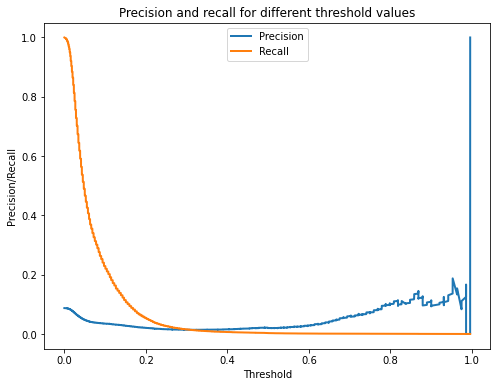

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df[:-1].True_class, error_df[:-1].Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
error_df[-500:-1]

,Reconstruction_error,True_class
228546,0.052642,1
228547,0.025073,1
228548,0.111531,1
228549,0.100654,1
228550,0.025077,1
...,...,...
229040,0.052625,1
229041,0.032402,1
229042,0.017041,1
229043,0.020066,1


In [ ]:
test = np.load("processed_data/x_test_filled.npz")['arr_0']
test -= 20
test /= 180

array([[0.41516668, 0.4097222 , 0.39888892, ..., 0.6538889 , 0.6484445 ,
        0.63761115],
       [0.23066667, 0.23066667, 0.21983333, ..., 0.41516668, 0.41516668,
        0.4097222 ],
       [0.30622223, 0.30622223, 0.30622223, ..., 0.3172222 , 0.31172222,
        0.31172222],
       ...,
       [0.35544446, 0.35005558, 0.3446111 , ..., 0.35544446, 0.35544446,
        0.35005558],
       [0.28427777, 0.2897778 , 0.28427777, ..., 0.42694443, 0.47633332,
        0.50922227],
       [0.37205556, 0.3611111 , 0.3666111 , ..., 0.4378889 , 0.4378889 ,
        0.43244442]], dtype=float32)

In [ ]:
y_test = lstm_autoencoder.predict(test[...,None])

In [ ]:
mse_test = np.mean(np.power(test - flatten(y_test), 2), axis=1)

threshold_fixed = 0.3

In [ ]:
sum(i > 0.23 for i in mse_test) 

9904

In [ ]:
np.max(mse_test)

0.8719413664303421

In [ ]:
answer = []

for p in mse_test:
  if p<=0.23:
    answer.append(0.1)
  elif p>0.23:
    answer.append(0.9)



In [ ]:
np.savetxt('pred/pred_y_0.23.txt', answer)